# Position Tracking using Kalman Filters
Written by Finley Marshall. \
Under the supervision of Philipp Wacker. \
This report and all the code used to produce it, are available on my __[GitHub](https://github.com/FinleyRMarshall/KalmanFilterProject)__. \
https://github.com/FinleyRMarshall/KalmanFilterProject

# Introduction
To track the position of a vehicle, one might use a sensor to observe the position and then estimate the position of the vehicle as that exact value. This approach uses no computational or memory resources, but when using a noisy sensor, the estimates will be inaccurate. A filter can help solve this problem by using computational and memory resources to reduce the noise of the sensor and give more accurate estimates. This project uses a Kalman Filter to filter out the noise from sensors and track the position of different vehicles, a satellite and remote control car.

# Kalman Filter 
The Kalman Filter model combines noisy sensor data and a prior belief of the system to estimate the current state of the system. The Kalman Filter predicts the next state and updates the state if a measurement is observed. The models' estimates of the system are often more accurate than the measurements and can provide more certain results. The model requires a small amount of memory and computational resources. The standard Kalman Filter model uses matrix multiplication and addition, basic computations for a computer, requires a maximum of $9$ matrices to be stored, which can be stored in primary memory for quick access. Thus, the model can run on a microcontroller and be implemented onboard most vehicles. 

## Notation
Will use the same notation used by Ma et al. (2020).\
$X_{n}$: The state of the model at time n\
$\hat{X}_{k|n}$: The state estimate at time k, given observations up to time n\
$\boldsymbol{P}_{n}$: The covariance of the state

$\boldsymbol{F}_{n}$: The state transition model

$\boldsymbol{B}_{n}$: The control input model\
$u_{n}$: The control vector

$w_{n}$: The process noise. $w_{n} \sim { \mathcal{N}}(0, Q_{n})$\
$\boldsymbol{Q}_{n}$: The covariance of process noise

$z_{n}$: The observation of the state\
$\boldsymbol{H}_{n}$: The observation model

$v_{n}$: The observation noise. $v_{n} \sim { \mathcal{N}}(0, R_{n})$\
$\boldsymbol{R}_{n}$: The covariance of observations

## Standard Kalman Filter
Using the standard Kalman Filter equations from Ma et al. (2020).  

The current state can be calculated from the last state, the controls and process noise.\
$X_{n} = \boldsymbol{F}_{n}X_{n-1} + \boldsymbol{B}_{n}u_{n} + w_{n}$

The observation of the state can be calculated from the current state and observation noise.\
$z_{n} = \boldsymbol{H}_{n}X_{n}+ v_{n}$

### Predict the next State
Prior of the state\
$\hat{X}_{n|n-1} = \boldsymbol{F}_{n}\hat{X}_{n-1|n-1} + \boldsymbol{B}_{n}u_{n}$

Priori covariance\
$\boldsymbol{P}_{n|n-1} = \boldsymbol{F}_{n}\boldsymbol{P}_{n-1|n-1}\boldsymbol{F}_{n}^{\mathsf{T}} + \boldsymbol{Q}_{n}$

### Update the State given a Measurement

Innovation pre-fit Residual\
$\tilde{y}_{k} = z_{n} - \boldsymbol{H}_{n}\hat{X}_{n|n-1}$

Innovation Covariance\
$\boldsymbol{S}_{n} =  \boldsymbol{H}_{n}\boldsymbol{P}_{n|n-1}\boldsymbol{H}_{n}^{\mathsf{T}} + \boldsymbol{R}_{n}$

Kalman gain\
$\boldsymbol{K}_{n} = \boldsymbol{P}_{n|n-1}\boldsymbol{H}_{n}^{\mathsf{T}}\boldsymbol{S}_{n}^{-1}$

State estimate\
$\hat{X}_{n|n} = \hat{X}_{n|n-1} + \boldsymbol{K}_{n}\tilde{y}_{n}$

Estimate Covariance\
$\boldsymbol{P}_{n|n} = (\boldsymbol{I} - \boldsymbol{K}_{n} \boldsymbol{H}_{n}) \boldsymbol{P}_{n|n-1}$

# Libraries
The following libraries will be used in this project. \
rc_car.py, satellite.py, titles.py are available on my __[GitHub](https://github.com/FinleyRMarshall/KalmanFilterProject/)__. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, radians, pi, sqrt
from rc_car import *
from satellite import *
from titles import *

# Satellite Example
The first example will be a satellite orbiting earth anticlockwise, moving in two dimensions $x_{1}$ and $x_{2}$. Using inaccurate measurements of the $x_1$ dimension, the Kalman Filter model will estimate the $x_1$ and $x_2$ dimension. The model can then be used to improve the satellites' real time position tracking.\
 \
The satellite could have operations to complete over certain areas of earth or space. Such operations could be communication, imaging or recharging. These operations could all be improved with a more accurate satellite position. With the large increase in space activity in recent years, the amount of orbital debris is increasing. With the improved position tracking, the satellite can more accurately report potential collisions, an increasing threat to satellites. Allowing for actions to be taken to avoid or minimize the damage to the satellite. 

## Deriving the Dynamical System

### Initial estimate, $\hat{X}_{0|0}$ and Initial covariance, $\boldsymbol{P}_{0}$
We will assume no prior information about the satellites' position is known. So we guess the position $(0,0)$, the center of the orbit. To tell the model, we are uncertain about this guess, we set the initial covariance to be the radius of the orbit. 
So we set, 
\begin{align} 
\hat{X}_{0|0} &= \begin{pmatrix} 0 \\ 0 \end{pmatrix} \\
\\
\boldsymbol{P}_{0} &= \begin{pmatrix} radius & 0 \\ 0 & radius \end{pmatrix}
\end{align}

### Control input model, $\boldsymbol{B}_{t}$ and Control vector, $u_{t}$
We are not modeling any controls the satellite might have due to simplicity. When the satellite uses the onboard controls, the model will view this as random movement.
Therefore, 
\begin{align} 
\boldsymbol{B}_{t} &= 0 \\
\\
u_{t} &= 0
\end{align}

### State transition model, $\boldsymbol{F}_{t}$
We now need to predict the next position of the satellite given its last position. We assume the satellite rotates the same $a$ radians anticlockwise every time unit. So every time step the satellite rotates, $at$ radians. The 2d plane is rotated by $at$ radians by the following matrix. 
$$\begin{pmatrix} cos(at) & -sin(at) \\ sin(at) & cos(at) \end{pmatrix}$$

We can use this matrix and the last position to predict the next position. The $w_{n}$ term accounts for the random movements of the satellite. 
\begin{align}
\boldsymbol{X}_{t+1} &= \begin{pmatrix} x_{1}(t+1) \\ x_{2}(t+1) \end{pmatrix} + w_{n} \\
 &= \begin{pmatrix} cos(at) & -sin(at) \\ sin(at) & cos(at) \end{pmatrix} \begin{pmatrix} x_{1}(t) \\ x_{2}(t) \end{pmatrix} + w_{n} \\
 &= \begin{pmatrix} cos(at) & -sin(at) \\ sin(at) & cos(at) \end{pmatrix}\boldsymbol{X}_{t} + w_{n}
\end{align}

The standard Kalman Filter requires the state transition matrix to contain linear terms, so it can't contain cos and sin terms. To solve this problem, we will use Euler's method to linearise the terms.  

Euler method:
$$\boldsymbol{X}_{t+1} = \boldsymbol{X}_{t}+h\boldsymbol{\dot{X}}_{t} + w_{n}$$

We need to work out the derivative, 
\begin{align}
\boldsymbol{\dot{X}}_{t} &= \begin{pmatrix} \dot{x}_{1}(t) \\ \dot{x}_{2}(t) \end{pmatrix} \\
 &= \begin{pmatrix} 0 & -a \\ a & 0\end{pmatrix} \begin{pmatrix} x_{1}(t) \\ x_{2}(t) \end{pmatrix} \\
 &= \begin{pmatrix} 0 & -a \\ a & 0\end{pmatrix} \boldsymbol{X}_{t}
\end{align}

Now we sub in the derivative to Euler method,

\begin{align}
\boldsymbol{X}_{t+1} &= \boldsymbol{X}_{t} + \begin{pmatrix} 0 & -a \\ a & 0 \end{pmatrix}\boldsymbol{X}_{t}h + w_{n} \\
  &= \begin{pmatrix} 1 & -ha \\ ha & 1 \end{pmatrix}\boldsymbol{X}_{t} + w_{n}
\end{align}

Now we have a linear state transition model,
$$
\boldsymbol{F}_{t} = \begin{pmatrix} 1 & -ha \\ ha & 1 \end{pmatrix}
$$

### Covariance of the process noise, $\boldsymbol{Q}_t$
We now have to work out how certain we are about our prediction of the next state, the covariance of the process noise. We know the satellite randomly moves from unknown causes that are drawn from a gaussian distribution with variance $q$. Thus, 
$$\boldsymbol{Q}_t = \begin{pmatrix} q & 0 \\ 0 & q \end{pmatrix}$$

## View the Dynamical system
We now have all the equations to create a satellite object and view the satellites' movement. 

### Satellite object
We first, create the satellite object, using the non-linear state transition model to simulate the satellite. We have the satellite start at a random position, at a set distance from $(0,0)$. All the lists stored by the satellite object are used for graphing and analysis purposes. The Satellite object can be viewed in __[satellite.py](https://github.com/FinleyRMarshall/KalmanFilterProject/blob/master/satellite.py)__.

### View the Satellites' movement
We can now view how the satellite is moving in time.

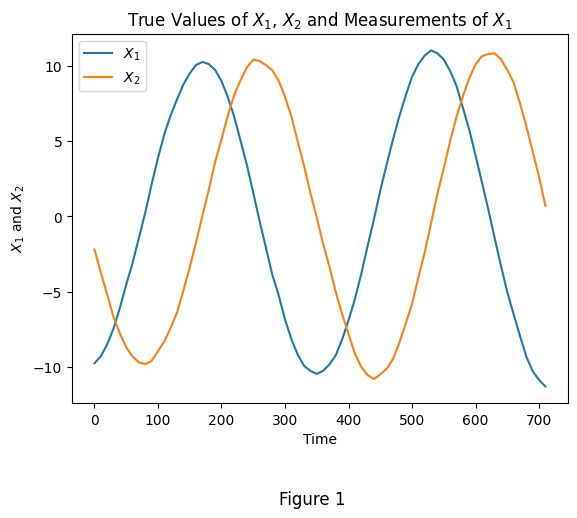

In [2]:
satellite = satellite_example()
satellite[0].graph(figure_txt=s_figure_txt[0], measurements = False)

## One Dimensional Position Measurements
The satellites' sensors can inaccurately observe the $x_1$ dimension. The model will use this measurement to estimate the position of the satellite in both dimensions. We also know the measurements of $x_1$ are drawn from a gaussian distribution, with variance of $r$. We can view the measurements for the satellite used before, below. 

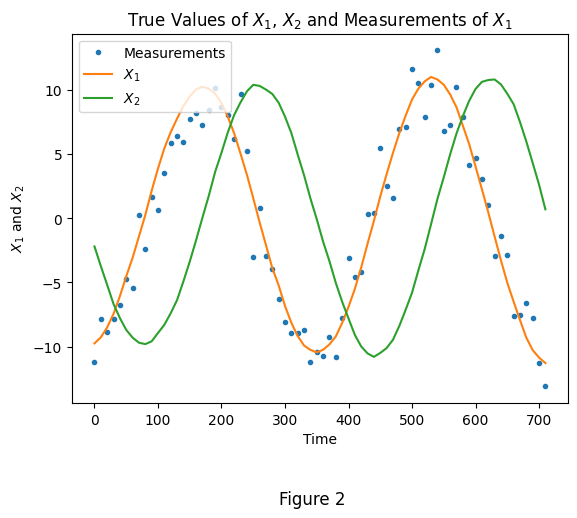

In [3]:
satellite[0].graph(figure_txt=s_figure_txt[1])

### Observation model, $\boldsymbol{H}_t$
We have to find what matrix pulls out the measurements from the state. 
The satellite measures its $x_1$ dimension. So,
$$z_t = x_1(t) + v_t$$
We also have the standard Kalman Filter equation for $z_t$
$$z_{t} = \boldsymbol{H}_{t}\boldsymbol{X}_{t}+ v_{t}$$
Combining the two equations gives, 
$$x_1(t) + v_t = \boldsymbol{H}_{t}\begin{pmatrix} x_{1}(t) \\ x_{2}(t) \end{pmatrix} + v_t $$
Which gives us the observation model, 
$$ \boldsymbol{H}_t = \begin{pmatrix} 1 & 0 \end{pmatrix}$$

### Covariance of the observations, $\boldsymbol{R}_t$
Lastly, we need to calculate how certain we are about the observations. We know the measurements of $x_1$ have a variance of $r$. So the covariance of the observation is simply,
$$\boldsymbol{R}_t = \begin{pmatrix} r \end{pmatrix}$$

## Kalman Filter object
We create a Kalman Filter object using the same notation described in the notation section. Which can be viewed in __[satellite.py](https://github.com/FinleyRMarshall/KalmanFilterProject/blob/master/satellite.py)__.

## Satellite Example Function
Now, we need to create a function to run the example. The values initialised below are passed to the function.
First, the function assigns all the values needed by the Kalman Filter. Then creates the Kalman Filter and Satellite with their respective inputs.
And finally, runs The Kalman Filter for a preset number of revolutions of the satellite and stores the estimates. 

In [4]:
h = 10 # Time step   
a = (pi * 2) / 360 # Angle changed every time step
r = 2 # Measurement variance
q = 0.1 # Movement variance
radius = 10 # Start radius
revolutions = 3 # Number of revolutions the satellite model will run for
receive_function = always_true 

In [5]:
def satellite_example(h, a, r, q, radius, revolutions, receive_function, start_angle=None):
    # Calculates how many times to run the model to get the desired number of revolutions 
    loop_count = satellite_loop_size(h, a, revolutions)
    
    # The same values as explained before
    X = np.array([0,0])
    F = np.array([[1, -a * h], [h * a, 1]])
    H = np.array([1, 0]).reshape(1, 2)
    Q = np.array([[q, 0], [0, q]])
    R = np.array([r])
    P = np.array([[radius, 0], [0, radius]])
    
    kf = KalmanFilter(f=F, h=H, q=Q, r=R, x=X, p=P)
    satellite = Satellite(a=a, h=h, q=q, r=r, radius=radius, start_angle=start_angle)

    prediction_data = []
    estimate_data = []
    
    # Run the model
    for i in range(loop_count):
        receive = receive_function(i)

        z = satellite.next_cord(receive=receive)

        x1, x2 = kf.predict()
        prediction_data.append((x1, x2, kf.p))

        if z is not None:
            x1, x2 = kf.update(z)
            estimate_data.append((x1, x2, kf.p))

    return satellite, prediction_data, estimate_data

In [6]:
satellite, prediction_data, estimate_data = satellite_example(h, a, r, q, radius, revolutions, receive_function)

## Satellite Model Estimates

### Model Estimates of $x_{1}$ 
We can view the estimates and the true values of $x_1$ below. We can also use the states' covariance to view the model's $99$% confidence interval (CI) for the estimates.

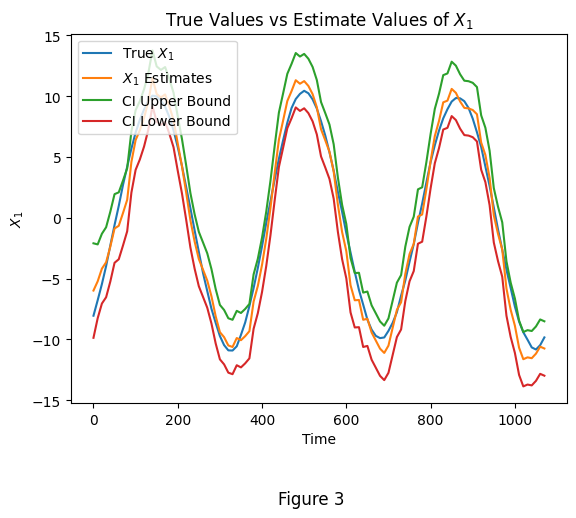

In [7]:
graph_x1_and_p(satellite, prediction_data, estimate_data, s_figure_txt[2])

### Model Estimates of $x_{2}$ 
Similarly to $x_1$, we can view the estimates, true values and $99$% CI for $x_2$ below.

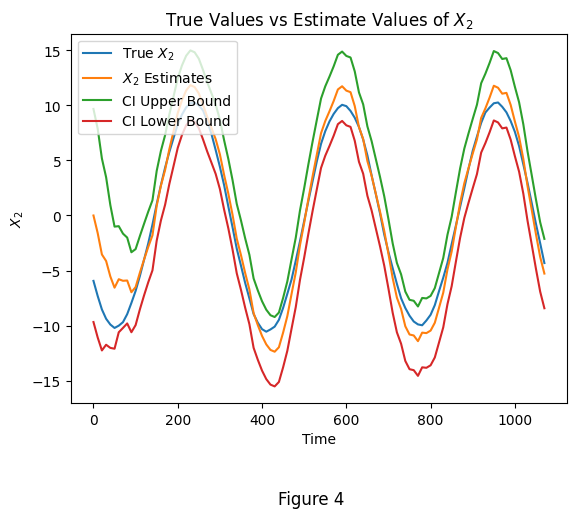

In [8]:
graph_x2_and_p(satellite, prediction_data, estimate_data, s_figure_txt[3])

## Analysis of the satellite model
Now we have a model for the satellite, but we do not know how good the model is. The Kalman Filter is meant to filter out the noise of the measurements, so we will compare the model's estimates to the measurements to test the model. We use the same values for the satellites' parameters as before. We calculate the average distance for the estimates and measurements of $1000$ satellites over $5$ revolutions for each time step. We can see the results belows.

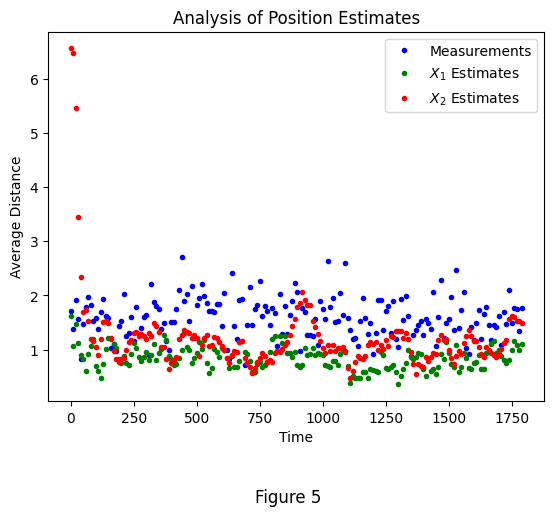

In [9]:
analysis_satellites = 10
analysis_revolutions = 5
satellite_analysis(analysis_satellites, analysis_revolutions, 'h', [10], s_figure_txt[4], title=s_plt_titles[0])

### Analysis Results
We now know the model preforms better than the measurements. The average distance of the estimates is below the average distance of the measurements. This means our model can be used to accurately track satellites.

## Finding the limits of the model
We will now test the limits of the model by increasing one of the parameters for the satellite and leaving the other parameters the same as before. We will then run the same test as before to determine if the model preforms better than the measurements.

### Increasing the Time Step
The current time step $h$ has been $10$. We will now change the model to observe a measurement every second time step, thus increasing the time step to $20$. 
The time step determines how often the satellite receives a measurement. Increasing the time step results in fewer measurements per revolution, this should increase the variance of the model and could lead to the model becoming more inaccurate than the measurements.

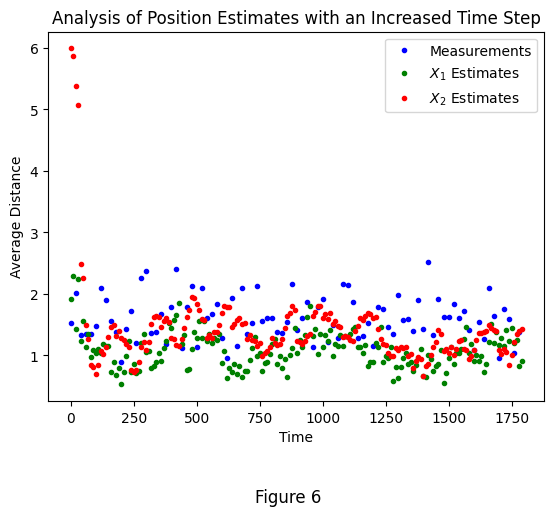

In [10]:
satellite_analysis(analysis_satellites, analysis_revolutions, 'h', [10], s_figure_txt[5], title=s_plt_titles[1], receive_values=[every_second])

### Time step Results
From the above graph we can see, even with the increased time step, the model has a lower distance than the measurements. The model is able to maintain a high accuracy, while observing measurement less frequently. 

### Increasing the Measurement Variance
The current measurement variance $r$ has been $2$, we will now increase this to $8$. The variance of the measurement noise, determines the spread of the measurement values. Increasing the measurement variance increases the average distance from the true value of $x_1$ to the measurement of $x_1$. The higher the measurement variance, the more noise has to be filtered out. This can cause the model to not see changes in the movement of the satellite because the movement is perceived as noise.

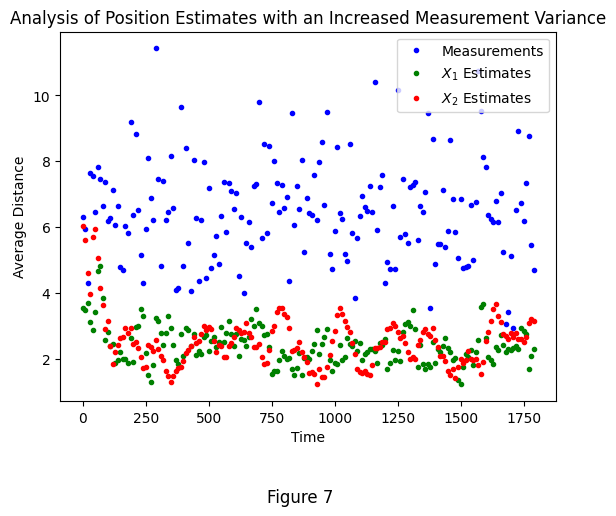

In [11]:
satellite_analysis(analysis_satellites, analysis_revolutions, 'r', [8], s_figure_txt[6], title=s_plt_titles[2])

### Measurement Variance Results
The model preforms better than the measurements with the increased measurement variance. The average distance for $x_1$ and $x_2$ is roughly half of the average measurement distance, thus the model is able to filter out large amounts of measurement noise.


### Increasing the Movement Variance
The current movement variance $q$ has been $0.1$, we will now increase this to $0.4$. The movement variance determines how much random movement occurs to the satellite. Increasing the movement variance results in the satellite movement becoming more random, and harder to track accurately. If the movement variance is too large, the model will not be able to predict the satellites' movement and the model will be less accurate than the measurements.

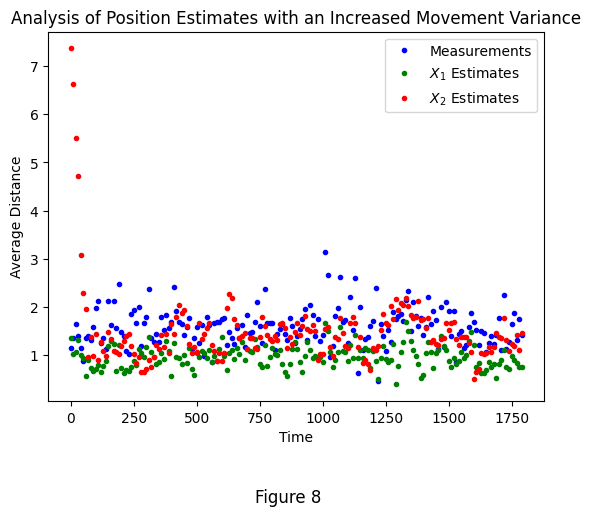

In [12]:
satellite_analysis(analysis_satellites, analysis_revolutions, 'q', [.4], s_figure_txt[7], title=s_plt_titles[3])

### Movement Variance Results
The model estimates' have a lower distance than the measurement distances. The model is able to preform under high values of movement variance, which results in a large amount of random satellite movement.

## Satellite Conclusion 
The Kalman Filter model tracks the position of the satellite in real time. The model was tested using randomly generated satellites and allowed the $x_1$ and $x_2$ coordinates to be estimated from noisy $x_1$ measurements. The model requires no prior information about the start state of the satellite, thus can be used on any satellite. The performance was not changed under large movement variance, large measurement variance or large time steps. The model uses a small amount of memory and requires very little computational resources, thus it can be implemented on a microcontroller onboard a satellite to improve the satellites' position tracking. This improved position tracking can be used to help improve the satellite operations and keep the satellite safe from collisions. 

# Remote Control (RC) Car
We now move on to our second example, remote control (RC) cars. We will now use the Extended Kalman Filter (EKF) model to improve the position tracking and add velocity tracking to RC cars in real time. There are multiple types of races, but to summarise, the RC cars want to have the shortest lap time. Drivers examine different routes of the track to find the fastest route for their car, the EKF model will provide useful data for the analysis of the routes.

We want our EKF model to be implemented onboard the remote control, so the driver can view the state in real time during a race and use this to influence their control inputs.
Drivers can also record the state of the model during practice runs, to view the position and velocity estimates of the car. They can also v With higher accuracy position data, the driver can map out the path the car took with a higher degree of accuracy. With the new velocity data, the driver can see the velocity of the car at every time of the race. This will be valuable data for the driver when examining and testing new routes on the track. 

We model the cheaper end of RC cars. These cars need to be as light as possible and only have essential instruments, such as a GPS system. They have no instruments to measure the velocity or acceleration of the car. The remote control inaccurately measurements the changes in forward acceleration and steering. 

We assume that the vertical dimension of the RC car is negligible, and thus the model only tracks two dimensions, $x_1$ and $x_2$. We also assume the magnitude of the cars' velocity is always above $0$ once the race has started, until the race has ended.


## Extended Kalman Filter (EKF)
We have to use an EKF model for the RC car because the controls of the car cannot be modelled by linear functions. In the normal EKF, the state transition model and control input model are combined, but this requires complex calculations when running the Kalman Filter. The normal EKF could not be done on a simple microcontroller, So we modify the equations. We keep the state transition model is a matrix and let the control input model be a non-linear function. This requires more computation resources than the Kalman Filter, but can be computed on a microcontroller and implemented onboard the remote control. 

Modifying Chui and Chen (2009) EKF equations results in:
$$X_{n} = \boldsymbol{F}_{n}X_{n-1} + \boldsymbol{B}_{n}(X_{n-1}, u_{n}) + w_{n}$$
Which changes the prior of the state,
$$\hat{X}_{n|n-1} = \boldsymbol{F}_{n}\hat{X}_{n-1|n-1} + \boldsymbol{B}_{n}(\hat{X}_{n-1|n-1}, u_{n})$$
The rest of the Kalman Filter equations remain the same. \
The Extended Kalman Filter object can be viewed in __[rc_car.py](https://github.com/FinleyRMarshall/KalmanFilterProject/blob/master/rc_car.py)__.

## Deriving the Dynamical System
### State $\boldsymbol{X}_{t}$
The state of the model will hold the following data at time $t$. \
$x_1$ dimension position as $x_1(t)$. \
$x_2$ dimension position as $x_2(t)$. \
$x_1$ velocity as $v_1(t)$. \
$x_2$ velocity as $v_2(t)$. \
All the positions and velocities will be absolute. \
Thus, 
$$ \boldsymbol{X}_{t} = \begin{pmatrix} x_1(t) \\ x_2(t) \\ v_1(t) \\ v_2(t) \end{pmatrix} $$

### Initial estimate, $\hat{X}_{0|0}$ and Initial covariance, $\boldsymbol{P}_{0}$
The RC car will start at $(0,0)$, the start of the track. The car will be on a slight downhill track in the positive $x_1$ direction, so the starting velocity will be $1cm/s$. \
Thus the initial estimate is, 
$$\hat{X}_{0|0} = \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0\end{pmatrix}$$
Will assume the start position is accurate to $10cm$ and the starting velocity to $1cm/s$. \
The starting initial covariance is, 
$$\boldsymbol{P}_{0} = \begin{pmatrix} 10 & 0 & 0 & 0 \\ 0 & 10 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ \end{pmatrix}$$

### State transition model, $\boldsymbol{F}_{t}$
We need to predict the next state of the car given the current state. We will do this using equations of motion. The following two equations of motion from Frauenfelder and Huber (2013) can be used, 
\begin{align}
v_n(t+1) &= v_n(t) + ah - khv_n(t) \\
d_n &= hv_n(t) + \frac{1}{2}ah^2
\end{align}
We have assumed that the drag force $k$ is directly proportional to velocity, this assumption will only hold at low speeds. 
Now, the state transition model does not take into account the effect of the remote control. Thus, we assume no forward acceleration or steering. We will now use the above equations to calculate the state transition model. 

\begin{align}
\boldsymbol{X}_{t+1} &= \begin{pmatrix} x_1(t +1) \\ x_2(t+1) \\ v_1(t+1) \\ v_2(t+1) \end{pmatrix} \\
\\
 &= \begin{pmatrix} x_1(t) + hv_1(t) \\ x_2(t) + hv_2(t) \\ v_1(t) - hkv_1(t) \\ v_2(t) - hkv_2(t) \end{pmatrix} + \boldsymbol{w}_t \\
\\
 &= \begin{pmatrix} x_1(t) + hv_1(t) \\ x_2(t) + hv_2(t) \\ [1-kh]v_1(t) \\ [1-kh]v_2(t) \end{pmatrix} + \boldsymbol{w}_t \\
\\
 &= \begin{pmatrix} 1 & 0 & h & 0 \\ 0 & 1 & 0 & h \\ 0 & 0 & 1-kh & 0 \\ 0 & 0 & 0 & 1-kh \end{pmatrix} \begin{pmatrix} x_1(t) \\ x_2(t) \\ v_1(t) \\ v_2(t) \end{pmatrix} + \boldsymbol{w}_t \\
\\
 &= \begin{pmatrix} 1 & 0 & h & 0 \\ 0 & 1 & 0 & h \\ 0 & 0 & 1-kh & 0 \\ 0 & 0 & 0 & 1-kh \end{pmatrix}\boldsymbol{X}_{t} + \boldsymbol{w}_t \\
\end{align}
We have derived the state transition model, 
$$\boldsymbol{F}_{t} = \begin{pmatrix} 1 & 0 & h & 0 \\ 0 & 1 & 0 & h \\ 0 & 0 & 1-kh & 0 \\ 0 & 0 & 0 & 1-kh \end{pmatrix}$$


### Control input model, $\boldsymbol{B}_{t + 1}(x_{t}, u_{t})$
The control input model is more complex than the state transition model, it models the impact of the remote control. The remote control changes the angle of the steering $\theta$ and the acceleration in the forward direction $\alpha$ of the car. We define a positive angle to be steering in the left direction relative to the car. Likewise, a negative angle will be in the right direction.

We let, 
\begin{align}
V(t) &= V_1(t) + V_2(t) \\
 &= \begin{pmatrix} V_1(t) \\ V_2(t) \end{pmatrix}
\end{align}

We will assume that the car's orientation is along the direction of $V$. We now calculate the change in V resulting from the rotation alone, with no forward acceleration to be considered. We can derive the following expression for the velocity $V(t+1)$ of the car from the velocity $V(t)$.
\begin{align}
V(t + 1) &= \begin{pmatrix} V_1(t+1) \\ V_2(t+1) \end{pmatrix} \\
 &= \begin{pmatrix} cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta) \end{pmatrix}\begin{pmatrix} V_1(t) \\ V_2(t) \end{pmatrix}
\end{align}

We next calculate the change in V resulting from forward acceleration alone, with no rotation to be considered.
We will use $|V(t+1)| = |V(t)| + \alpha h$, (Frauenfelder & Huber, 2013). 
\begin{align}
|V(t+1)| &= |V(t)| + \alpha h \\
 &= \sqrt{[v_1(t)]^2 + [v_2(t)]^2} + \alpha h
\end{align}
With only forward acceleration the angle of $V(t+1)$ and $V(t)$, $\phi$ will not change. We can use this to calculate the change in V.

From V(t) we get,
$$cos(\phi) = \frac{V_1(t)}{|V(t)|}$$

From V(t + 1) we get,
$$cos(\phi) = \frac{V_1(t+ 1)}{|V(t + 1)|}$$

This gives us the following equation, 
\begin{align}
\frac{V_1(t+ 1)}{|V(t + 1)|} &= \frac{V_1(t)}{|V(t)|} \\
\\
V_1(t+ 1) &= \frac{|V(t + 1)|}{|V(t)|}V_1(t) \\
\\
 &= \frac{|V(t)| + \alpha h}{|V(t)|}V_1(t) \\
\\
 &=  V_1(t) \begin{pmatrix} 1+ \frac{\alpha h}{|V(t)|} \end{pmatrix}\\
\end{align}

And a similar calculation leads to, 
$$V_2(t+ 1) =  V_2(t) \begin{pmatrix} 1+ \frac{\alpha h}{|V(t)|} \end{pmatrix}$$

We now have an equation for $V(t+1)$, when only considering forward acceleration.

$$ V(t+1) = V(t)\begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|}\end{pmatrix}$$

We now have an equation for $V(t+1)$, when only considering rotation and when only considering forward acceleration. We can combine the two equations to give us an equation for $V(t+1)$ considering rotation and forward acceleration. This gives us, 

\begin{align}
V(t+1) &= \begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|}\end{pmatrix}\begin{pmatrix} cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta) \end{pmatrix}V(t) \\
\\
 &= \begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|}\end{pmatrix} \begin{pmatrix} V_1(t)cos(\theta) -  V_2(t)sin(\theta) \\ V_1(t)sin(\theta) + V_2(t)cos(\theta) \end{pmatrix} \\
\\
 &= \begin{pmatrix} 
\begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)cos(\theta) - V_2(t)sin(\theta) \end{pmatrix} \\ 
\\
\begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)sin(\theta) + V_2(t)cos(\theta) \end{pmatrix} 
\end{pmatrix}
\end{align}

We now have an equation for the velocity when the car is accelerating. Next, we derive an equation for the distance travelled when the car is accelerating. 

We will use $d = \frac{h}{2}[V(t+1) + V(t)]$, which assumes constant acceleration over the period of $h$, (Frauenfelder & Huber, 2013). 

\begin{align}
d(t+1) &= \begin{pmatrix} d_1(t+1) \\ d_2(t+1) \end{pmatrix} \\
\\
 &= \begin{pmatrix} \frac{h}{2} \begin{pmatrix} V_1(t) + V_1(t+1) \end{pmatrix} \\ \frac{h}{2} \begin{pmatrix} V_2(t) + V_2(t+1) \end{pmatrix} \end{pmatrix} \\
\\
 &= \begin{pmatrix} 
\frac{h}{2} \begin{pmatrix} V_1(t) + \begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)cos(\theta) - V_2(t)sin(\theta) \end{pmatrix} \end{pmatrix} \\ 
\frac{h}{2} \begin{pmatrix} V_2(t) + \begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)sin(\theta) + V_2(t)cos(\theta) \end{pmatrix} \end{pmatrix} 
\end{pmatrix} 
\end{align}

The control input model, $\boldsymbol{B}_{t}$, uses both $V(t)$ and $d(t)$.
Have to adjust for transition model, $\boldsymbol{F}_{t}$, by subtracting off the added distances and velocities added in the transition model. 

\begin{align}
\boldsymbol{B}_{t + 1}(x_{t}, u_{t}) &= \begin{pmatrix} d_1(t+1) - hV_1(t) \\ d_2(t+1) - hV_2(t)\\ V_1(t+1) - V_1(t) \\ V_2(t+1) - V_2(t)\end{pmatrix} \\
\\
 &= 
\begin{pmatrix}
\frac{h}{2} \begin{pmatrix} V_1(t) + \begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)cos(\theta) - V_2(t)sin(\theta) \end{pmatrix} \end{pmatrix} - hV_1(t) \\
\frac{h}{2} \begin{pmatrix} V_2(t) + \begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)sin(\theta) + V_2(t)cos(\theta) \end{pmatrix} \end{pmatrix} - hV_2(t) \\
\begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)cos(\theta) - V_2(t)sin(\theta) \end{pmatrix} - V_1(t) \\
\begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)sin(\theta) + V_2(t)cos(\theta) \end{pmatrix} - V_2(t)
\end{pmatrix} \\
\\
 &= 
\begin{pmatrix}
\frac{h}{2} \begin{pmatrix} -V_1(t) + \begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)cos(\theta) - V_2(t)sin(\theta) \end{pmatrix} \end{pmatrix} \\
\frac{h}{2} \begin{pmatrix} -V_2(t) + \begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)sin(\theta) + V_2(t)cos(\theta) \end{pmatrix} \end{pmatrix} \\
\begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)cos(\theta) - V_2(t)sin(\theta) \end{pmatrix} - V_1(t) \\
\begin{pmatrix} 1 + \frac{\alpha h}{|V(t)|} \end{pmatrix} 
\begin{pmatrix} V_1(t)sin(\theta) + V_2(t)cos(\theta) \end{pmatrix} - V_2(t)
\end{pmatrix}
\end{align}

The EKF model will use the following function to calculate the control input model.

In [13]:
def rc_car_control_input_model(x,  h, alpha, theta):
    # Controls for the rc car
    # The explanation for this function can be found in the control input model section
    x_1, x_2, v_1, v_2 = x
    mag_v = sqrt(v_1**2 + v_2**2)
    scalar_factor = 1 + (alpha * h)/(mag_v)
    new_x_1 = h/2*(-v_1 + scalar_factor*(v_1*cos(theta) - v_2*sin(theta)))
    new_x_2 = h/2*(-v_2 + scalar_factor*(v_1*sin(theta) + v_2*cos(theta)))
    new_v_1 = scalar_factor*(v_1*cos(theta) - v_2*sin(theta)) - v_1
    new_v_2 = scalar_factor*(v_1*sin(theta) + v_2*cos(theta)) - v_2
    return np.array([new_x_1, new_x_2, new_v_1, new_v_2])


## View the Dynamical System
We can now have all equations to simulate and view the RC car. 

### RC Car object
We use the control input model and state transition model to simulate the RC car. The GPS and control measurements are returned, which are explained later. The controls are read form the $control file$, with $\alpha$ $\theta$ on each line for each time step. All the lists stored by the object are used for graphing and analysis purposes. The RC car object can be viewed in __[rc_car.py](https://github.com/FinleyRMarshall/KalmanFilterProject/blob/master/rc_car.py)__.

### View the RC Cars' path 
We can now see the RC car going around a racetrack below. The car starts at $(0, 0)$.

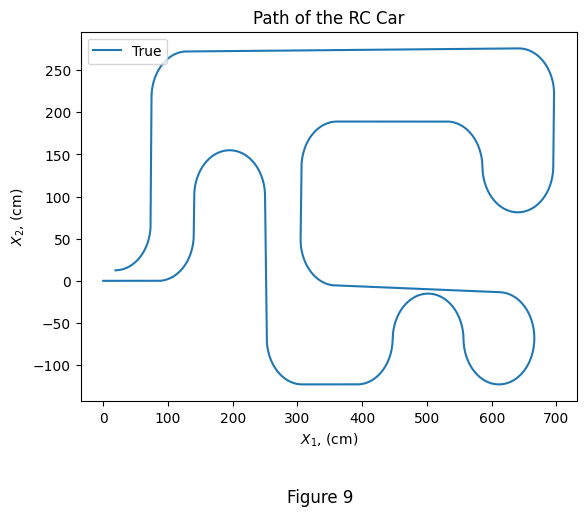

In [14]:
rc_car = rc_car_example()
graph_car(rc_car[0], rc_car[1], c_figure_txt[0], output='9')

## Control Measurements

### Covariance of the process noise, $\boldsymbol{Q}_t$
The remote control changes the angle of the steering, $\theta$ and the acceleration $\alpha$ in the forward direction of the car. We assume the remote control measurements of $\alpha$ are drawn from a gaussian distribution with a variance of $0.1$ and the measurements of $\theta$ are drawn from a gaussian distribution with a variance of $0.01$. Thus, we let, 
$$\boldsymbol{Q}_t = \begin{pmatrix} 0.01 & 0 & 0 & 0 \\ 0 & 0.01 & 0 & 0 \\ 0 & 0 & 0.01 & 0 \\ 0 & 0 & 0 & 0.01 \\ \end{pmatrix}$$

The following graph shows the RC car going around the same racetrack. The estimate is an RC car following the noisy control measurements; the EKF will be given. We can see the paths of the RC cars quickly diverge.  

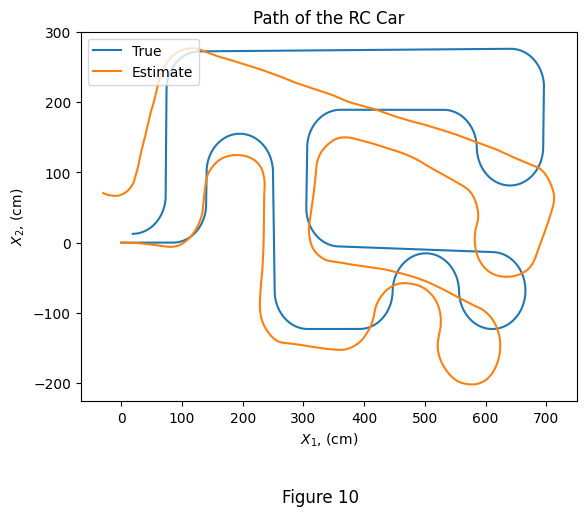

In [15]:
track_car_no_measurements = rc_car_example(receive_function=always_false)
graph_car(track_car_no_measurements[0], track_car_no_measurements[1], c_figure_txt[1], output='2')

## GPS Measurements

### Observation model, $\boldsymbol{H}_t$
The RC car has a GPS, which observes measurements of the $x_1$ and $x_2$ dimension. 
Thus, 
$$\boldsymbol{H}_t = \begin{pmatrix} 1 & 0 & 0& 0 \\ 0 & 1 & 0 & 0 \end{pmatrix}$$

### Covariance of the observations, $\boldsymbol{R}_t$
We assume the GPS measurements of $x_1$ and $x_2$ are drawn from a gaussian distribution, with variance of $r^2$. We assume an outdoor track, with no cover above the track, to interfere with GPS instruments. Consumer grade GPS systems have a standard deviation of at least $60cm$, (Wing et al., 2005). We will use the lower bound for the RC car GPS, so $r=60$.
Thus, 
\begin{align}
\boldsymbol{R}_t &= \begin{pmatrix} r^2 & 0 \\ 0 & r^2 \end{pmatrix} \\
 &= \begin{pmatrix} 60^2 & 0 \\ 0 & 60^2 \end{pmatrix}
\end{align}

We can view the GPS measurements for $x_1$ below when the RC car goes in a straight line at a constant speed. We can view the large noise of the GPS measurements.

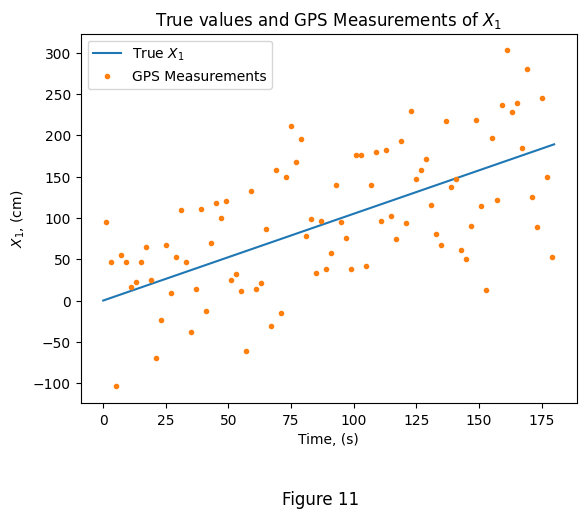

In [16]:
straight_car_short = rc_car_example(loop_count=180, control_file='controls/straight_line_controls.txt')
graph_car(straight_car_short[0], straight_car_short[1], c_figure_txt[2],  output='7')

## RC Car Example function
We now have all the equations, matrices and objects to run the EKF model. We first assign all the values used by the EKF object and RC car object. 
Then, create the EKF and RC car objects and finally, run the EKF model, storing the state and covariance of the state at each time step. \
The $loopcount$ is the number of controls inputs for the given file, this can be adjusted to ignore later controls if needed. 
We have used a time step of $1$ and assume GPS measurements occur every 2 seconds. We set the drag force to $0.1$, so a small amount of deceleration occurs on the RC car.

In [17]:
def rc_car_example(h=1, k=0.1, r=60, loop_count=3028, control_file='controls/track_controls.txt', receive_function=every_second, alpha_variance=0.1, theta_variance=0.01):
    F = np.array([[1, 0, h, 0], [0, 1, 0, h], [0, 0, 1 - k * h, 0], [0, 0, 0, 1 - k * h]])
    X = np.array([0, 0, 1, 0])
    H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    P = np.array([[10, 0, 0, 0], [0, 10, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    R = np.array([[r ** 2, 0], [0, r ** 2]])
    Q = np.array([[.01, 0, 0, 0], [0, .01, 0, 0], [0, 0, .01, 0], [0, 0, 0, .01]])

    kf = RC_Car_EKF(f=F, h=H, q=Q, r=R, p=P, x=X, time_step=h)
    car = RC_car(k=k, h=h, r=r, control_file=control_file, alpha_variance=alpha_variance, theta_variance=theta_variance)

    car_data = [(kf.x, kf.p)]

    for i in range(loop_count):
        receive = receive_function(i)
        x1, x2, alpha, theta = car.next_movement(receive)

        kf.predict(alpha, theta)
        if x1 is not None:
            kf.update(np.array([x1, x2]))

        car_data.append((kf.x, kf.p))

    car.close_file()
    return car, car_data

## EKF Model
We now use the EKF model to combine the GPS and control measurements to estimate the position and velocity of the RC car.
We can view the performance of the model in three different scenarios below. 

### Straight line
The first scenario is a simple straight line over a long time period. We can view the models' estimates for the position of the RC car below.

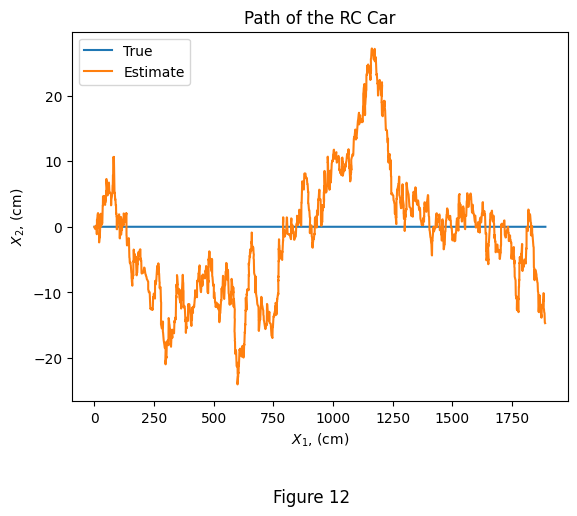

In [18]:
Straight_line = rc_car_example(h=1, k=0.1, r=60, loop_count=1800, receive_function=every_second, control_file='controls/straight_line_controls.txt')
graph_car(Straight_line[0], Straight_line[1], c_figure_txt[3], output='2')

### Corner
The second scenario is a left turn. We can view the models' estimates for the position of the RC car below.

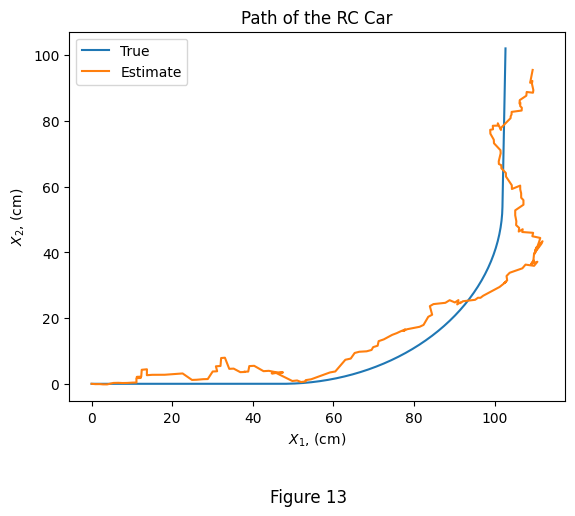

In [19]:
corner = rc_car_example(h=1, k=0.1, r=60, loop_count=172, receive_function=every_second, control_file='controls/corner_controls.txt')
graph_car(corner[0], corner[1], c_figure_txt[4], output='2')

### Racetrack
The third scenario is a realistic path an RC car would take during a race. We can view the models' estimates for the position of the RC car below.

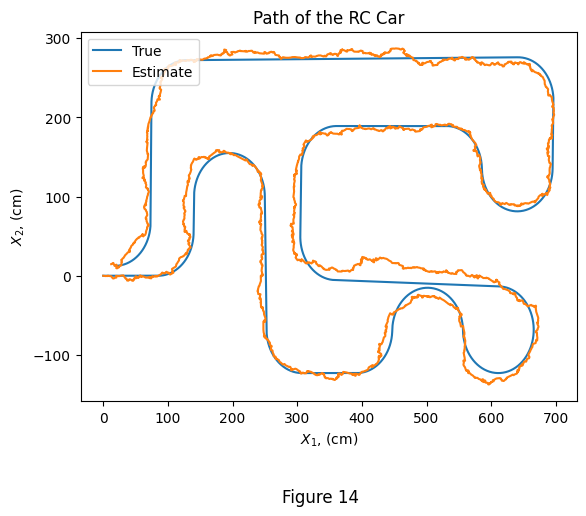

In [20]:
track_car = rc_car_example(h=1, k=0.1, r=60, loop_count=3028, receive_function=every_second, control_file='controls/track_controls.txt')
graph_car(track_car[0], track_car[1], c_figure_txt[5], output='2')

### Variance of Position Estimates
We can also view the $99$% CI for the estimates of $x_1$ and $x_2$, when the car goes around the racetrack depicted above.
We use the covariance of the state matrix to compute the $99$% CI. The following graphs show the $99$% CI for the estimates of $x_1$ and $x_2$.

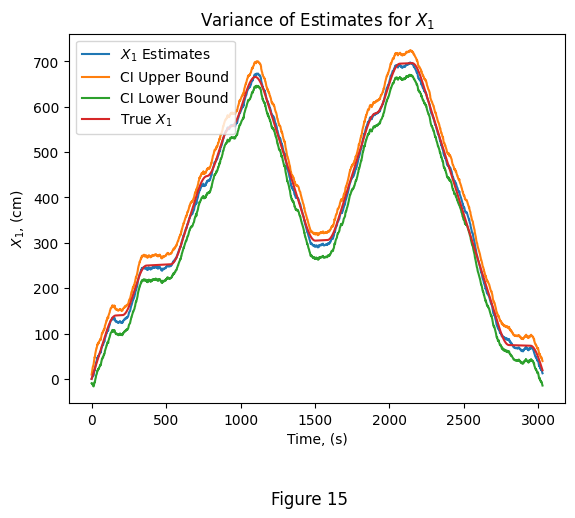

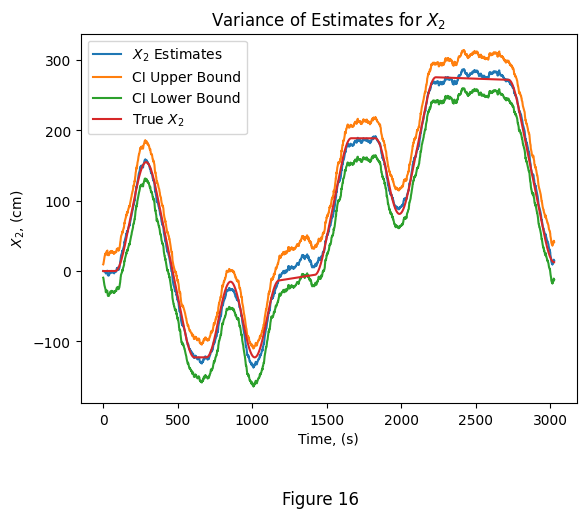

In [21]:
graph_car(track_car[0], track_car[1], c_figure_txt[6], output='5')
graph_car(track_car[0], track_car[1], c_figure_txt[7], output='6')

### Variance of Velocity Estimates 
We also have new information about the velocity of the car from the EKF model. The velocity of the car is based on the noisy control measurements, and is not influenced by the GPS data. Without the EKF model, no data on the velocity of the car would be available. The RC car is going around the same racetrack used above. We can view the $99$% CI for the $v_1$ and $v_2$ estimates below. 

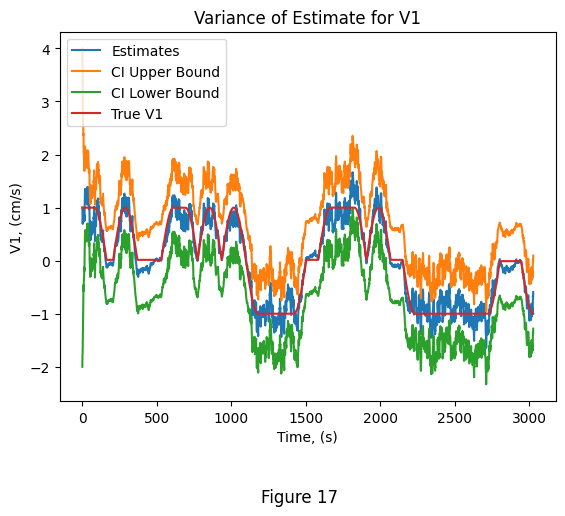

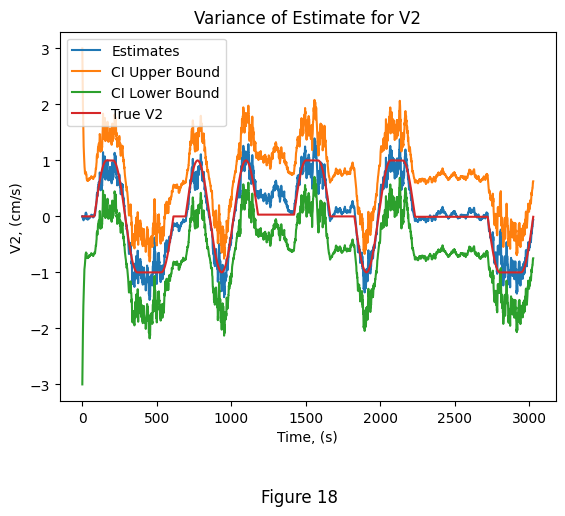

In [22]:
graph_car(track_car[0], track_car[1], c_figure_txt[8], output='a')
graph_car(track_car[0], track_car[1], c_figure_txt[9], output='b')

## Analysis for RC Car
We have just shown the model tracks the RC car quite well, and it seems better than the GPS measurements. We will now confirm this by analysing the EKF model. 

### Position Accuracy Analysis
We will examine the distance between the position estimate and the true position of the car. We will also examine the distance between the GPS measurement and the true position of the car. We will simulate $100$ cars completing the racetrack used before. The racetrack has straight lines, left turns and right turns in multiple different orders throughout the track. This will test the models' accuracy during all the expected movements of an RC car during a race. The measurement distances and estimate distances will be plotted on the box plot below.

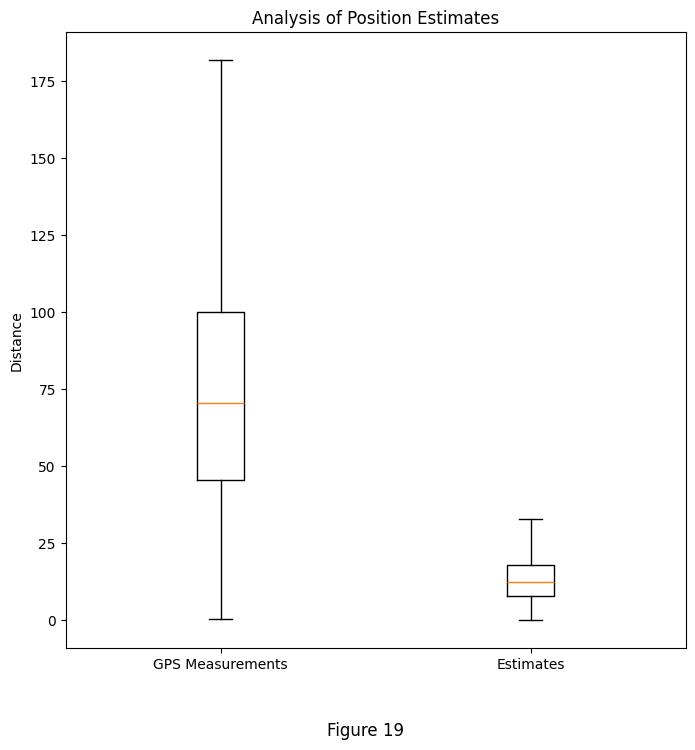

In [23]:
car_position_analysis(100, c_figure_txt[10], c_plt_titles[0])

### Position Accuracy Results
We can see the models' position estimates distances are significantly lower than the measurement distances. When using the EKF model, the position estimate of the RC car has a medium of $13cm$. This is a decrease of $73-13 = 60cm$ from the measurement distances. $75$% of the position estimates have a distance of less than $18cm$. These statistics ensure the drivers can be confident in the position of the car produced by the model.  

### Velocity Accuracy Analysis
We will now analysis the velocity estimates. We will examine the difference between the velocity estimate and the true velocity of the car. We simulate $100$ cars going around the same racetrack. The difference between the true and estimates of $v_1$ and $v_2$ are shown below on the box plot.


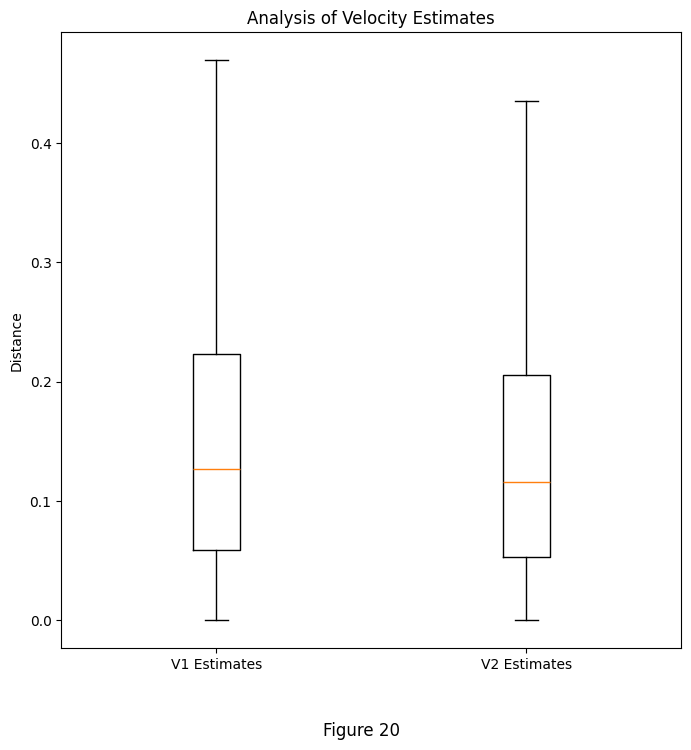

In [24]:
car_velocity_analysis(100, c_figure_txt[11], c_plt_titles[1])

### Velocity Accuracy Results
Both box plots are both distributed the same, which is expected. With a medium of $0.12cm / s$ and upper quartile of $0.23cm / s$, the model is able to provide reliable velocity data to the drivers of the RC cars. The velocity of the RC car can't be observed without the EFK model, so there is no measurement data to compare to.

## RC Car Conclusion
The EFK model supplies position and velocity estimates in real time for the RC car. The model uses very few computation resources and could be implemented onboard the remote control, so the data is visible to the driver in real time. The model observes extremely noisy GPS measurements and noisy control measurements. The position estimates have a medium distance of $13cm$, a significant decrease from the measurements. The velocity estimates have a medium distance of $0.12cm / s$ and provide the driver with new crucial information. The driver can view the state of the model in real time to view the cars' current position and velocity, this data can then influence their decision for next steps in the race. The position and velocity estimates can be graphed and viewed to help determine if the route was optimal and what changes needed to be made. The EFK model is able to provide drivers with data, to help them reduce their lap time and be the best RC car driver they can be. 

# Kalman Filter Conclusion 
A Kalman Filter model and an Extended Kalman Filter model have been implemented to improve position tracking of satellites and RC cars, respectively. Both models use very few computation and memory resources and can be implemented on a small mirco controller. The models provide the estimates in real time and can be stored for analysis. The models have shown accurate position estimates are feasible with noisy sensors.

# References
Chui, C. K., & Chen, G. (2009). Kalman Filtering with Real-Time Applications. Springer. https://doi.org/10.1007/978-3-540-87849-0 \
\
Frauenfelder, P., & Huber, P. (2013). Introduction to Physics. Elsevier.\
\
Ma, H., Yan, L., Xia, Y., & Fu, M. (2020). Kalman Filtering and Information Fusion. Springer. https://doi.org/10.1007/978-981-15-0806-6 \
\
Wing, M. G., Eklund, A., & Kellogg, L. D. (2005). Consumer-Grade Global Positioning System (GPS) Accuracy and Reliability. Journal of Forestry, 103(4), 169–173. https://doi.org/10.1093/jof/103.4.169
